In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
# importing grid search
from sklearn.model_selection import GridSearchCV
# import our models
#Logistic Regression
from sklearn.linear_model import LogisticRegression
#linear SVC
from sklearn.svm import LinearSVC
#random forest
from sklearn.ensemble import RandomForestClassifier
#xgboost
from xgboost import XGBClassifier


plt.style.use("ggplot")

In [ ]:
#%pip install xgboost

In [2]:
# Loading our data
data_base = pd.read_pickle('data_base.pkl')
data_base.head()

,date,home_team,away_team,season,home_win,home_rolling_fg,home_rolling_fga,home_rolling_fg%,home_rolling_3p,home_rolling_3pa,...,away_rolling_opponent_drb%_max,away_rolling_opponent_trb%_max,away_rolling_opponent_ast%_max,away_rolling_opponent_stl%_max,away_rolling_opponent_blk%_max,away_rolling_opponent_tov%_max,away_rolling_opponent_usg%_max,away_rolling_opponent_ortg_max,away_rolling_opponent_drtg_max,away_rolling_opponent_Total
0,2021-01-08,LAL,CHI,2020-21,1,44.000000,86.000000,0.510333,12.166667,31.500000,...,37.683333,25.166667,43.016667,5.083333,8.016667,47.266667,33.933333,193.000000,121.000000,119.333333
1,2021-01-09,MIL,CLE,2020-21,1,45.166667,88.666667,0.509833,16.666667,39.333333,...,37.966667,25.133333,48.700000,7.500000,6.566667,56.333333,31.833333,176.000000,109.500000,101.333333
2,2021-01-10,BRK,OKC,2020-21,0,44.666667,90.333333,0.493333,13.166667,36.166667,...,43.883333,25.016667,60.833333,5.333333,5.883333,47.533333,34.033333,169.833333,113.166667,106.500000
3,2021-01-10,GSW,TOR,2020-21,1,41.333333,87.500000,0.470833,14.000000,38.166667,...,44.950000,26.050000,48.866667,5.050000,12.916667,56.100000,32.033333,187.500000,123.166667,115.166667
4,2021-01-11,WAS,PHO,2020-21,1,44.000000,91.833333,0.479167,12.500000,34.833333,...,45.833333,25.966667,40.816667,4.550000,8.533333,38.566667,38.783333,208.333333,119.833333,108.166667


In [3]:
info_cols = ['date',
 'home_team',
 'away_team',
 'season',
 'home_win' ]


Creating our list of information columns. Note that these variables are all present before a game actually happens. 

In [4]:
# Splitting the data into train and test
X = data_base.loc[:, ~data_base.columns.isin(info_cols)] # excluding info_cols
y = data_base['home_win']

print(f'Feature set shape: {X.shape}, target series shape: {y.shape}')

Feature set shape: (2027, 264), target series shape: (2027,)


We need to perform Feature Scaling when we are dealing with Gradient Descent Based algorithms (Linear and Logistic Regression, Neural Network) and Distance-based algorithms (KNN, K-means, SVM) as these are very sensitive to the range of the data points.

In [52]:
#importing the data scaling and pipeline libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

#Creating a class that initializes the model and the parameters, and we just need to pass the scaling method for the pipeline

class ModelParams:
        """ Info:
         This class initializes the parameters, and we just need to pass the model and scaling method for the pipeline. """
         
        
        
    

       
    
        #creating the models  parameters dictionary
        # Parameters of pipelines can be set using '__' separated parameter names:
        
        models_params = {
            'LogisticRegression': {'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'], 'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100], 'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'logisticregression__max_iter': [10000]},
            'LinearSVC': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'loss': ['hinge', 'squared_hinge'], 'max_iter': [10000]},
            'RandomForestClassifier': {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
            'XGBClassifier': {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [5, 10, 15, 20, 25, 30], 'learning_rate': [0.001, 0.01, 0.1, 1], 'min_child_weight': [1, 3, 5], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]}
        }
            
        
        
       


              
      
       

In [32]:

# creating a class to take in the model and return the metrics of this model with the best parameters,
# using for this the GridSearchCV function
class ModelDevelopment:
    """ Takes in the model, the X and y data and splits the data into train and test sets.
    Functions:
    - grid_search: Takes in the parameters to be tested and the scoring metric and returns the best model, best parameters and best score
    - model_metrics: Prints the accuracy, precision, recall, f1 and auc of best model parameters found by the grid search against the test set
    - roc_curve: Plots the ROC curve of the best model parameters found by the grid search against the test set"""

    def __init__(self, model, model_name, X, y, scaling_method):
        """ Info:
            Takes in the model, the X and y data and splits the data into train and test sets.

            Input:
            model: Model to be tested
            model_name: Name of the model to be tested
            X: Feature set
            y: Target series
            scaling_method: Scaling method to be used in the pipeline

            Output:
            X_train: Feature set for the train set
            X_test: Feature set for the test set
            y_train: Target series for the train set
            y_test: Target series for the test set
            pipe: Pipeline with the scaling method and the model
                    """
        self.model = model
        self.model_name = model_name
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        self.scaling_method = scaling_method
        self.pipe = make_pipeline(self.scaling_method, self.model)

        
    

    def grid_search(self, params, scoring): # scoring is the metric we want to optimize, mostly 'roc_auc'
        """ Info:
            Takes in the parameters to be tested and the scoring metric and returns the best model, best parameters and best score
             Input:
              params: Dictionary with the parameters to be tested
              scoring: Metric to be optimized
             Output:
              best_model: Best model found by the grid search
              best_params: Best parameters found by the grid search
              best_score: Best score found by the grid search """
        
        grid = GridSearchCV(self.pipe, params, cv=5, scoring=scoring, n_jobs=-1)
        grid.fit(self.X, self.y)
        self.best_model = grid.best_estimator_
        self.best_params = grid.best_params_
        self.best_score = grid.best_score_
        return self.best_model, self.best_params, self.best_score
        
    
    def model_metrics(self):
        """ Prints the accuracy, precision, recall, f1 and auc of best model parameters found by the grid search against the test set
            For this, we use the pre split X test and y test data, which are 20% of the original data
          """
        y_pred = self.best_model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        auc = roc_auc_score(self.y_test, y_pred)
        print('Accuracy: ', accuracy)
        print('Precision: ', precision)
        print('Recall: ', recall)
        print('F1: ', f1)
        print('AUC: ', auc)
        
    
    def roc_curve(self):
        """ Plots the ROC curve of the best model parameters found by the grid search against the test set
            For this, we use the pre split X test and y test data, which are 20% of the original data
          """
        y_pred_proba = self.best_model.predict_proba(self.X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred_proba)
        plt.plot([0,1], [0,1], 'k--')
        plt.plot(fpr, tpr, label=self.model_name)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(self.model_name+' ROC Curve')
        plt.show()

In [53]:
# instantiating the model, with the model name, the X and y data and the scaling method
LR = ModelDevelopment(LogisticRegression(random_state=42), 'Logistic Regression', X, y, StandardScaler())



In [54]:
LR.grid_search(ModelParams.models_params['LogisticRegression'], 'roc_auc')


In [42]:
# running the grid search function, passing the parameters and the scoring metric
LR.grid_search(ModelParams.models_params['LogisticRegression'], 'roc_auc')

ValueError: Invalid parameter C for estimator Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [37]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

Accuracy:  0.7044334975369458
Precision:  0.7245762711864406
Recall:  0.7566371681415929
F1:  0.7402597402597403
ROC AUC:  0.7565634218289086
Confusion Matrix:  [[115  65]
 [ 55 171]]


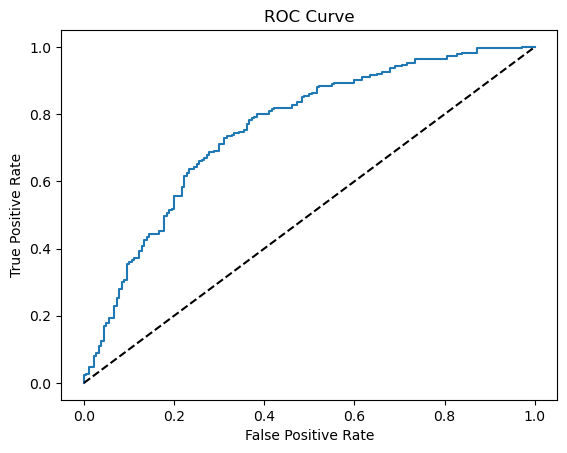

In [12]:
# defining our models
model = LogisticRegression(max_iter=10000)

# creating an object
model_development = ModelDevelopment(X_train, y_train, X_test, y_test)

# fitting the model
model_development.fit_model(model)

# predicting the model
model_development.predict()

# evaluating the model

model_development.evaluate_model()

# plotting the ROC curve

model_development.plot_roc_curve()